In [1]:
from utils import *

#%matplotlib widget

# libraries for Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

# libraries for features selectiona
# ANOVA F-test
from sklearn.feature_selection import f_classif
from sklearn import datasets

# library for standardize features
from sklearn.preprocessing import StandardScaler

# libraries for epsilon parameter
from sklearn.neighbors import NearestNeighbors

# libraries for Clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# libraries for Adjusted Rand Index
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# libraries for general utilities
import numpy as np 
from matplotlib import pyplot as plt
import utilities as uti

# global variables from work specifications
SEED = 42
set_seed(SEED)
NUMBER_FEATURES = 6
NEIGHBOURS = 5

In [2]:
def findEpsParams(features):
    
    neigh = NearestNeighbors(n_neighbors=NEIGHBOURS)
    nbrs = neigh.fit(features)
    distances, indices = nbrs.kneighbors(features)
    
    print(distances)

    distances = np.sort(distances, axis=0)[:,NEIGHBOURS-1]
    plt.plot(distances)
    plt.axhline(y=3.4, xmin=0, xmax=250, linestyle='-', c='red')
    plt.show()

    return 3.4

In [3]:
##
## DATASET LOADING
##

# create the loader class and load dataset and labels
loader = Loader().load()

# get dataset, labels, and dataset splitted by classes
dataset = loader.getDataset()
labels = loader.getLabels()
class_split_dataset = loader.getClassSplitDataset()



In [4]:
dataset.shape

(563, 2500)

In [5]:
##
## FEATURES CREATION
##

# extract 6 features wirh PCA
pca = PCA(n_components=NUMBER_FEATURES)
pca_dataset_embedded = pca.fit_transform(dataset)

# extract 6 features wirh t-sne
tsne = TSNE(n_components=NUMBER_FEATURES, method='exact')
tsne_dataset_embedded = tsne.fit_transform(dataset)

# extract 6 features wirh isomap
isomap = Isomap(n_components=NUMBER_FEATURES)
isomap_dataset_embedded = isomap.fit_transform(dataset)

# features concatenate (6,6,6) = 18 features
features = np.concatenate((pca_dataset_embedded,tsne_dataset_embedded, isomap_dataset_embedded), axis=1)

In [6]:
# standardization
scaler = StandardScaler()
features_std = scaler.fit_transform(features)
ids = labels[:,0]
labels = labels[:,1]

In [7]:
print(features_std.shape)
print(labels.shape)

(563, 18)
(563,)


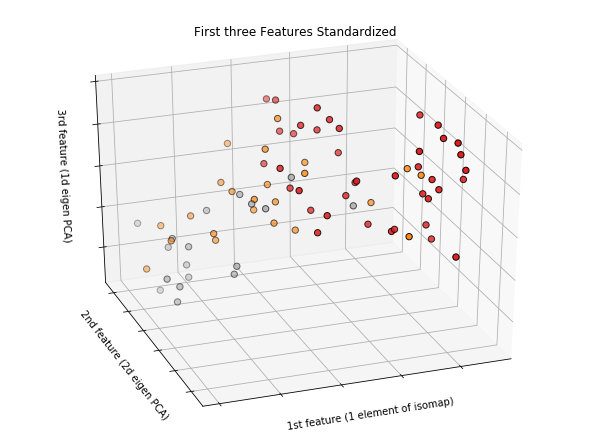

In [8]:
from mpl_toolkits.mplot3d import Axes3D

feat = features_std[labels!=0]
lbs = labels[labels!=0]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(feat[:, 13], feat[:, 2], feat[:, 1], c=lbs,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three Features Standardized")
ax.set_xlabel("1st feature (1 element of isomap)")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd feature (2d eigen PCA)")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd feature (1d eigen PCA)")
ax.w_zaxis.set_ticklabels([])

plt.show()

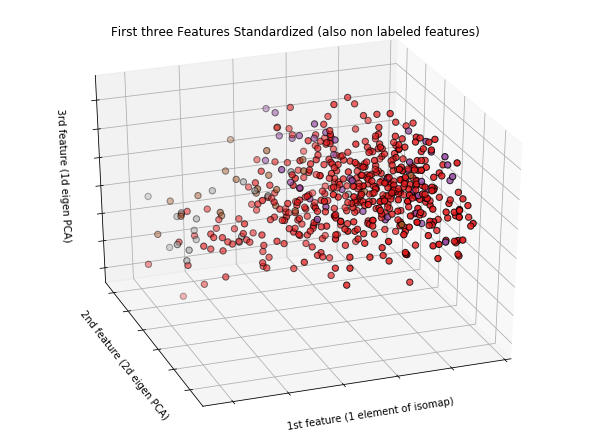

In [9]:
fig = plt.figure(2, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(features_std[:, 13], features_std[:, 2], features_std[:, 1], c=labels,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three Features Standardized (also non labeled features)")
ax.set_xlabel("1st feature (1 element of isomap)")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd feature (2d eigen PCA)")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd feature (1d eigen PCA)")
ax.w_zaxis.set_ticklabels([])

plt.show()

Classification accuracy without selecting features: 0.762
Classification accuracy after selection (Normalized): 0.762
Classification accuracy after selection (Standardize): 0.762
Classification accuracy after selection (MinMax norm): 0.762


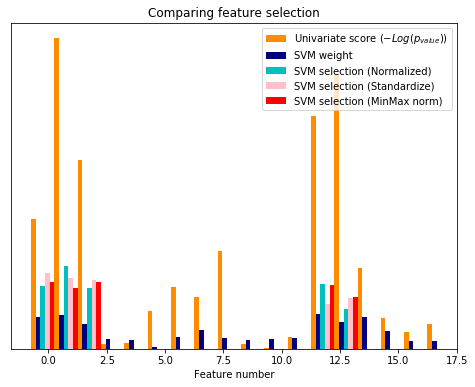

In [10]:
# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

fig = plt.figure(3, figsize=(8, 6))

feat = features_std[labels!=0]
lbs = labels[labels!=0]

k_selection = 5

# Some noisy data not correlated
#E = np.random.RandomState(42).uniform(0, 0.1, size=(feat.shape[0], 20))

# Add the noisy data to the informative features
#feat = np.hstack((feat, E))

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        feat, lbs, stratify=lbs#, random_state=0
)

selector = SelectKBest(f_classif, k=k_selection)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(feat.shape[-1])
plt.bar(X_indices - .65, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')#,edgecolor='black')

# #############################################################################
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .45, svm_weights, width=.2, label='SVM weight',
        color='navy')#,edgecolor='black')

# #############################################################################
# SVM on Normalized input

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=k_selection), #MinMaxScaler(), 
        Normalizer(),
    LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after selection (Normalized): {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .25, svm_weights_selected,
        width=.2, label='SVM selection (Normalized)', color='c')#,edgecolor='black')


# #############################################################################
# SVM on Standardize input

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=k_selection), #MinMaxScaler(), 
        StandardScaler(),
    LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after selection (Standardize): {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM selection (Standardize)', color='pink')#,edgecolor='black')


# #############################################################################
# SVM on MinMax Normalized input

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=k_selection), 
    MinMaxScaler(),
    LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after selection (MinMax norm): {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] + .15, svm_weights_selected,
        width=.2, label='SVM selection (MinMax norm)', color='red')#,edgecolor='black')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')


plt.show()

In [11]:
selector.get_params()

{'k': 5,
 'score_func': <function sklearn.feature_selection.univariate_selection.f_classif(X, y)>}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001120CA16C88>,
      dtype=object)

<Figure size 576x432 with 0 Axes>

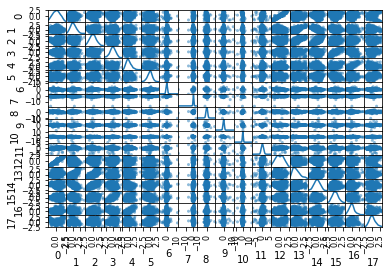

In [12]:
from pandas.plotting import scatter_matrix
from pandas import DataFrame

fig = plt.figure(4, figsize=(8, 6))
scatter_matrix(DataFrame(features_std), alpha=0.5, diagonal='kde')

In [13]:
fig = plt.figure(5, figsize=(6, 4))
corr = abs(DataFrame(features_std).corr())
corr.style.background_gradient(cmap='coolwarm').format("{:.3}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,7.56e-17,4.32e-17,6.39e-17,4.85e-17,1.1e-16,0.165,0.218,0.416,0.0331,0.333,0.26,0.943,0.145,0.139,0.0152,0.0518,0.0286
1,7.56e-17,1.0,6.57e-17,2.81e-17,1.03e-16,1.72e-17,0.252,0.157,0.0647,0.0853,0.123,0.0296,0.207,0.61,0.573,0.23,0.0886,0.0434
2,4.32e-17,6.57e-17,1.0,4.41e-17,1.86e-17,4.07e-17,0.179,0.0848,0.0603,0.0292,0.119,0.21,0.0185,0.658,0.578,0.117,0.182,0.0338
3,6.39e-17,2.81e-17,4.41e-17,1.0,5.9e-16,3.91e-16,0.116,0.0498,0.0871,0.0837,0.00982,0.0655,0.00618,0.0926,0.173,0.728,0.351,0.139
4,4.85e-17,1.03e-16,1.86e-17,5.9e-16,1.0,1.21e-16,0.00432,0.0337,0.0894,0.0148,0.0282,0.0574,0.0571,0.0288,0.287,0.29,0.705,0.155
5,1.1e-16,1.72e-17,4.07e-17,3.91e-16,1.21e-16,1.0,0.0776,0.0532,0.0284,0.00997,0.032,0.155,0.0178,0.0116,0.0117,0.287,0.0282,0.278
6,0.165,0.252,0.179,0.116,0.00432,0.0776,1.0,0.168,0.267,0.00294,0.261,0.0275,0.192,0.272,0.0638,0.0177,0.0238,0.0287
7,0.218,0.157,0.0848,0.0498,0.0337,0.0532,0.168,1.0,0.02,0.281,0.0931,0.211,0.244,0.021,0.128,0.0218,0.042,0.0866
8,0.416,0.0647,0.0603,0.0871,0.0894,0.0284,0.267,0.02,1.0,0.145,0.138,0.178,0.447,0.00592,0.073,0.0144,0.148,0.0165
9,0.0331,0.0853,0.0292,0.0837,0.0148,0.00997,0.00294,0.281,0.145,1.0,0.118,0.0691,0.0233,0.126,0.0612,0.0116,0.0389,0.0571


<Figure size 432x288 with 0 Axes>

In [14]:
(xs, ys) = np.where((corr>0.5)==True)

In [15]:
pairs = [ [x, y] for x,y in zip(xs, ys) if x>y ]

In [16]:
indexes = np.array([int(x) for x in np.union1d(np.ravel(pairs),[])])

In [17]:
pairs

[[12, 0], [13, 1], [13, 2], [14, 1], [14, 2], [15, 3], [16, 4]]

[[None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, None],
 [None, No

<Figure size 720x720 with 0 Axes>

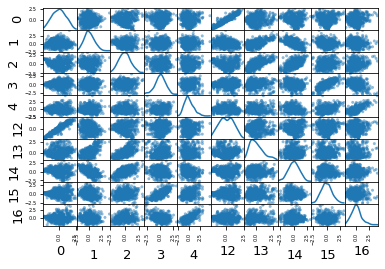

In [18]:
fig = plt.figure(6, figsize=(10, 10))
Axes = scatter_matrix(DataFrame(features_std[:,indexes], columns=indexes), alpha=0.5, diagonal='kde')

#y ticklabels
[plt.setp(item.yaxis.get_majorticklabels(), 'size', 5) for item in Axes.ravel()]
#x ticklabels
[plt.setp(item.xaxis.get_majorticklabels(), 'size', 5) for item in Axes.ravel()]
#y labels
[plt.setp(item.yaxis.get_label(), 'size', 13) for item in Axes.ravel()]
#x labels
[plt.setp(item.xaxis.get_label(), 'size', 13) for item in Axes.ravel()]

In [19]:
##
## FEATURES REMOVING
##

b = np.arange(features_std.shape[1])
b = np.setdiff1d(b,np.array(pairs)[:,0])

features_sel = features_std[:,b]

In [20]:
b

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 17])

In [21]:
##
## FEATURES EXTRACTION
##

# selection with ANOVA F-test
f,prob = f_classif(features_sel, labels)
indexes = np.arange(len(f))
app = [ [i, ele] for i, ele in enumerate(f)]
app.sort(key = lambda app: app[1], reverse = True)
indexes = np.array([ int(a) for a in np.array(app)[:,0]])
print(indexes)
f = f[indexes]
print(np.round(f, 3))
prob = prob[indexes]
print(np.round(prob, 3))

[ 2  1  0 10  6  4 11  7  5 12  8  3  9]
[32.718 19.248 12.796  5.209  3.523  3.433  3.134  1.991  1.899  1.393
  0.88   0.632  0.346]
[0.    0.    0.    0.001 0.015 0.017 0.025 0.114 0.129 0.244 0.451 0.595
 0.792]


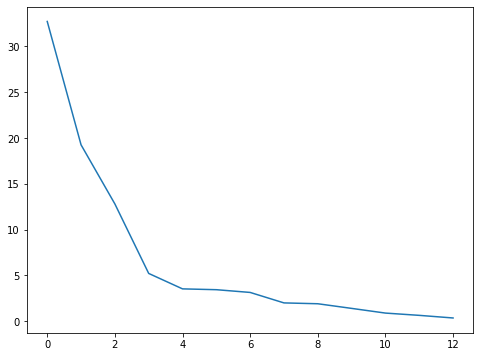

In [22]:
##
## FEATURES SELECTION
##
fig = plt.figure(7, figsize=(8, 6))
plt.plot(f)
plt.show()

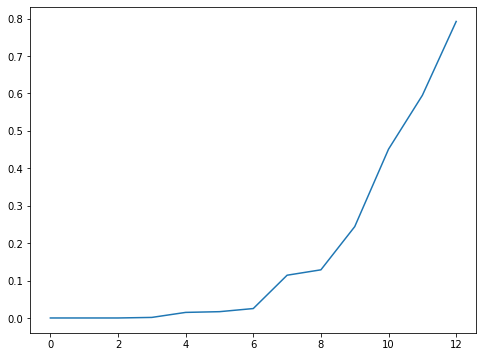

In [23]:
##
## FEATURES SELECTION
##
fig = plt.figure(8, figsize=(8, 6))
plt.plot(prob)
plt.show()

In [24]:
features_sel

array([[ 0.50737362,  0.81217425, -1.7296963 , ...,  0.14550437,
         1.19383019, -0.84559932],
       [-1.81344778, -1.0587843 ,  1.26329608, ...,  1.17239638,
        -0.23837615,  2.45329041],
       [ 1.02701125,  0.85590214,  1.17518616, ..., -0.98594343,
        -0.26141804,  0.00797348],
       ...,
       [ 0.58118132, -0.21295937, -2.08570393, ...,  0.32948413,
         0.42588471,  0.30222182],
       [ 0.03839273,  0.792216  ,  2.23434328, ..., -0.59344771,
        -1.19757077, -1.37918009],
       [-0.56866479, -0.23555241, -0.56664235, ...,  0.45162278,
        -0.14092433, -0.43078506]])

In [25]:
features_last_sel = features_sel[:,indexes]
features_last_sel

array([[-1.7296963 ,  0.81217425,  0.50737362, ..., -0.30597938,
        -1.25439394,  0.66227378],
       [ 1.26329608, -1.0587843 , -1.81344778, ...,  0.55426779,
         0.55863665, -0.94415581],
       [ 1.17518616,  0.85590214,  1.02701125, ..., -0.32353084,
         3.15162204,  0.28794709],
       ...,
       [-2.08570393, -0.21295937,  0.58118132, ..., -0.08960638,
         0.06175028,  0.22384314],
       [ 2.23434328,  0.792216  ,  0.03839273, ..., -0.2456566 ,
         1.13694454,  0.48634829],
       [-0.56664235, -0.23555241, -0.56866479, ..., -0.09345147,
        -0.65515123, -0.5521922 ]])

[[0.         1.61642044 1.805148   2.05387213 2.05867582]
 [0.         1.00732058 1.52892819 1.53570304 1.58996527]
 [0.         2.19801421 2.59984084 2.80324878 2.8483988 ]
 ...
 [0.         1.41000503 1.45806834 1.71739868 1.83077068]
 [0.         1.27997323 1.3355658  1.8671107  2.02028373]
 [0.         1.19013797 1.19038623 1.24493223 1.4036437 ]]


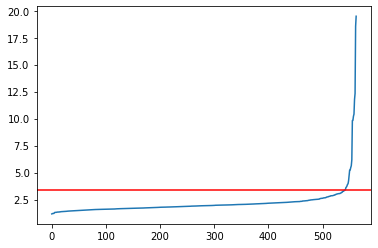

In [26]:
##
##  CLUSTERING
##

# selecting manually the epsilon params for DBSCAN
eps = findEpsParams(features_sel)

In [27]:
#k-means
import utilities as uti

n_cluster_max = 10
n_cluster_min = 4
n_feat = 6

vlarray=uti.take_valid_labels(labels)
featu = features_sel[:,indexes[:n_feat]]
val_int, val_ext, k_labels_for_k= uti.kmeans_all_results(featu,n_cluster_min,n_cluster_max,vlarray)

In [28]:
print("val for ",n_feat," features")
print(val_int)
print()
print(val_ext)

val for  6  features
[[4, 0.20272728620319355], [5, 0.18784518503094128], [6, 0.2084541299400876], [7, 0.21364430749706217], [8, 0.19165639552593708], [9, 0.19163432374937778], [10, 0.19545929216508362]]

[[4, 0.09524812241173583], [5, 0.26023230088495575], [6, 0.10472867064469499], [7, 0.07010824523321467], [8, 0.08630063516004234], [9, 0.13993424948440977], [10, 0.10966834229771519]]


In [29]:
best_k=4 #choosed number of clusters
##best_k=choose_best_k(val_int,val_ext) to implement?
report_clusters(ids, k_labels_for_k[best_k-2], "tp2_data/KMEANS_"+str(best_k)+"cluster"+str(n_feat)+"feat.html")

In [30]:
#n_feat_max=9
#all=kmeans_all_results_for_different_features(featu,indexes,n_cluster_max,n_feat_max,vlarray)


In [31]:
#bisecting k-means

In [32]:
n_clust=8
n_feat=3

features_last_sel = features_sel[:,indexes[:n_feat]]

res_real_bi=uti.new_BiKMemans_predict(n_clust,featu)

report_clusters_hierarchical(ids,res_real_bi,"tp2_data/NewBiKmeans"+str(n_clust)+"cluster"+str(n_feat)+"feat.html")

In [33]:
#another method of clustering: agglomerative

In [34]:
n_cluster_max = 10
n_feat = 4

vlarray=uti.take_valid_labels(labels)
featu = features_sel[:,indexes[:n_feat]]

int_aggl, ext_aggl, label_aggl = uti.aggl_all_results(featu,n_cluster_min,n_cluster_max,vlarray)


In [35]:
int_aggl = np.array(int_aggl)
int_aggl[np.where(int_aggl == np.max(int_aggl, 0)[1])[0][0]][0]

6.0

In [36]:
best_int_k=int(int_aggl[np.where(int_aggl == np.max(int_aggl, 0)[1])[0][0]][0])
report_clusters(ids, k_labels_for_k[best_k-2], "tp2_data/AGGLOMERATIVE_"+str(best_k)+"cluster"+str(n_feat)+"feat.html")

In [37]:
ext_aggl


[[4, 0.25019066069409257],
 [5, 0.2447645452754243],
 [6, 0.2447645452754243],
 [7, 0.260770308656346],
 [8, 0.2099534051595613],
 [9, 0.20211743015559303],
 [10, 0.19246961748465338]]

In [38]:
best_ext_k=int(ext_aggl[np.where(ext_aggl == np.max(ext_aggl, 0)[1])[0][0]][0])
if best_ext_k!= best_int_k:
    report_clusters(ids, k_labels_for_k[best_k-2], "tp2_data/AGGLOMERATIVE_"+str(best_k)+"cluster"+str(n_feat)+"feat.html")

In [50]:

n_cluster_min=2
n_cluster_max=6
resu=uti.clustering_valutation_visualization("Agglomerative",ids,labels,featu,n_cluster_min,n_cluster_max,uti.aggl_all_results)

the best k, according to the internal index is:  6
Visualization in the file:  tp2_data/Agglomerative_6cluster4feat_int.html
the best k, according to the external index is:  3
Visualization in the file:  tp2_data/Agglomerative_3cluster4feat_ext.html


In [51]:
resu=uti.clustering_valutation_visualization("K-means",ids,labels,featu,n_cluster_min,n_cluster_max,uti.kmeans_all_results)

the best k, according to the internal index is:  6
Visualization in the file:  tp2_data/K-means_6cluster4feat_int.html
the best k, according to the external index is:  4
Visualization in the file:  tp2_data/K-means_4cluster4feat_ext.html


In [52]:

resu=uti.clustering_valutation_visualization("Mixture",ids,labels,featu[:,:3],n_cluster_min,n_cluster_max,uti.mixture_all_results)

the best k, according to the internal index is:  4
Visualization in the file:  tp2_data/Mixture_4cluster3feat_int.html
the best k, according to the external index is:  3
Visualization in the file:  tp2_data/Mixture_3cluster3feat_ext.html


In [42]:
n_cluster=12
n_feat=6
uti.bisect_kmeans_visualization(ids,featu,n_feat,n_cluster)

Visualization in the file:  tp2_data/NewBiKmeans12cluster6feat.html


In [43]:
n_feat=featu.shape[1]
n_feat

4

In [44]:
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit_predict(featu)

array([2, 0, 3, 0, 2, 2, 2, 3, 0, 2, 0, 1, 2, 2, 3, 0, 3, 2, 3, 2, 2, 3,
       2, 3, 0, 2, 0, 2, 0, 2, 0, 2, 3, 0, 0, 0, 2, 2, 3, 2, 3, 0, 2, 1,
       2, 2, 3, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 0, 3, 2, 2,
       3, 2, 0, 0, 3, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1,
       2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 3, 0, 2, 0, 2, 2, 0, 0, 3, 0, 0,
       3, 0, 2, 3, 2, 0, 0, 2, 0, 2, 3, 0, 3, 0, 2, 2, 3, 0, 0, 2, 2, 3,
       2, 2, 3, 2, 2, 0, 0, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 0,
       2, 2, 2, 2, 3, 2, 2, 0, 0, 3, 2, 2, 2, 0, 0, 3, 3, 3, 0, 3, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 0, 2, 2, 0, 2, 3, 0, 2, 0, 2, 3,
       1, 0, 0, 0, 3, 2, 2, 0, 3, 0, 0, 0, 0, 2, 0, 2, 2, 1, 3, 3, 0, 0,
       2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 0, 3, 2, 0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 0, 2, 3, 3, 2, 2, 2,
       0, 2, 0, 3, 2, 3, 0, 2, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 2, 3, 2, 2,
       2, 2, 3, 3, 0, 2, 0, 3, 0, 2, 0, 2, 3, 2, 2,

In [45]:
def clustering_valutation_visualization(file_prefix,ids,featu,n_cluster_max,vlarray,f1):
    
    int_aggl, ext_aggl, label_aggl = f1(featu,n_cluster_max,vlarray)
    
    int_aggl = np.array(int_aggl)
    int_aggl[np.where(int_aggl == np.max(int_aggl, 0)[1])[0][0]][0]
    best_int_k=int(int_aggl[np.where(int_aggl == np.max(int_aggl, 0)[1])[0][0]][0])
    
    report_clusters(ids, k_labels_for_k[best_int_k-2], "tp2_data/"+file_prefix+"_"+str(best_int_k)+"cluster"+str(n_feat)+"feat.html")
    ext_aggl = np.array(ext_aggl)
    best_ext_k=int(ext_aggl[np.where(ext_aggl == np.max(ext_aggl, 0)[1])[0][0]][0])
    if best_ext_k!= best_int_k:
        report_clusters(ids, k_labels_for_k[best_ext_k-2], "tp2_data/"+file_prefix+"_"+str(best_ext_k)+"cluster"+str(n_feat)+"feat.html")
    
    